In [1]:
import matplotlib
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt

## Pull In Data

In [2]:
 # Import SQLAlchemy `automap` and other dependencies here
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

In [3]:
# Create an engine for the `hawaii.sqlite` database
engine = create_engine("sqlite:///hawaii.sqlite")

In [4]:
# Reflect Database into ORM class
Base = automap_base()
Base.prepare(engine, reflect=True)

In [5]:
# Print all of the classes mapped to the Base
Base.classes.keys()

['measurement', 'station']

In [6]:
#Save the classes 
Measurement = Base.classes.measurement
Station = Base.classes.station

In [7]:
# Create a session
session = Session(engine)

## Dig Into Database

In [8]:
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [9]:
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [10]:
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


## Precipitation Analysis

In [11]:
#Most Recent Date
most_recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
most_recent_date

('2017-08-23')

In [12]:
#Query to  retrieve the last 12 months of percipitation data
prioryear = dt.date(2017, 8, 23) - dt.timedelta(days =365)
rainfall = session.query(Measurement.date, Measurement.prcp).\
             filter(Measurement.date > prioryear).\
             order_by(Measurement.date).all()
#rainfall[0]

In [13]:
#Turn the query into a Pandas DF and sort 
rainfalldf = pd.DataFrame(rainfall)
rainfalldf.set_index('date')
rainfalldf = rainfalldf.sort_index(ascending = True)
rainfalldf.head()

,date,prcp
0,2016-08-24,0.08
1,2016-08-24,2.15
2,2016-08-24,2.28
3,2016-08-24,NaN
4,2016-08-24,1.22


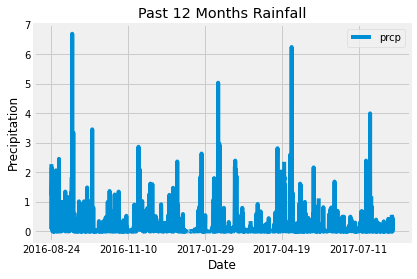

In [23]:
#Plot the results using the DataFrame plot method
rainfalldf.plot('date', 'prcp')
plt.title('Past 12 Months Rainfall')
plt.xlabel('Date')
plt.ylabel('Precipitation')
plt.show()

In [15]:
#Using Pandas, print the summary statistics for the precipitation data
rainfalldf.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


## Station Analysis

In [16]:
#Query to find total number of stations
station_count = session.query(Station).count()
station_count

9

In [17]:
#Query to find the most active stations (i.e. which stations have the most rows?)
Activity = (session.query(Measurement.station, func.count(Measurement.station)).\
group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all())
Activity

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [18]:
Most_Active = Activity[0][0]
Most_Active

'USC00519281'

In [19]:
#Design a query to retrieve the last 12 months of temperature observation data (TOBS)
#Filter by the station with the highest number of observations

TOBS_Filter = session.query(Measurement.station, Measurement.date, Measurement.tobs).\
                filter(Measurement.station == Most_Active).\
                filter(Measurement.date > prioryear).order_by(Measurement.date).all()

#Turn the query into a Pandas DF
TOBS = pd.DataFrame(TOBS_Filter)
TOBS

,station,date,tobs
0,USC00519281,2016-08-24,77.0
1,USC00519281,2016-08-25,80.0
2,USC00519281,2016-08-26,80.0
3,USC00519281,2016-08-27,75.0
4,USC00519281,2016-08-28,73.0
...,...,...,...
346,USC00519281,2017-08-14,77.0
347,USC00519281,2017-08-15,77.0
348,USC00519281,2017-08-16,76.0
349,USC00519281,2017-08-17,76.0


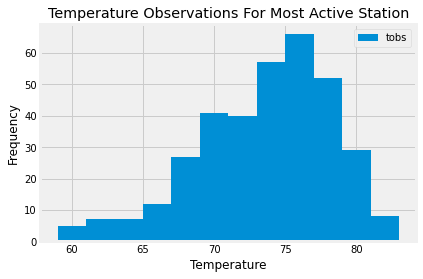

In [27]:
#Plot the results as a histogram with bins=12
TOBS.set_index('date')
TOBS.plot.hist(bins=12)
plt.title('Temperature Observations For Most Active Station')
plt.xlabel('Temperature')
plt.show()